# ANN with PyTorch - Fashion MNIST


# Import libraries

In [46]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchinfo import summary

In [47]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [48]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# import dataset

In [49]:
# import dataset
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

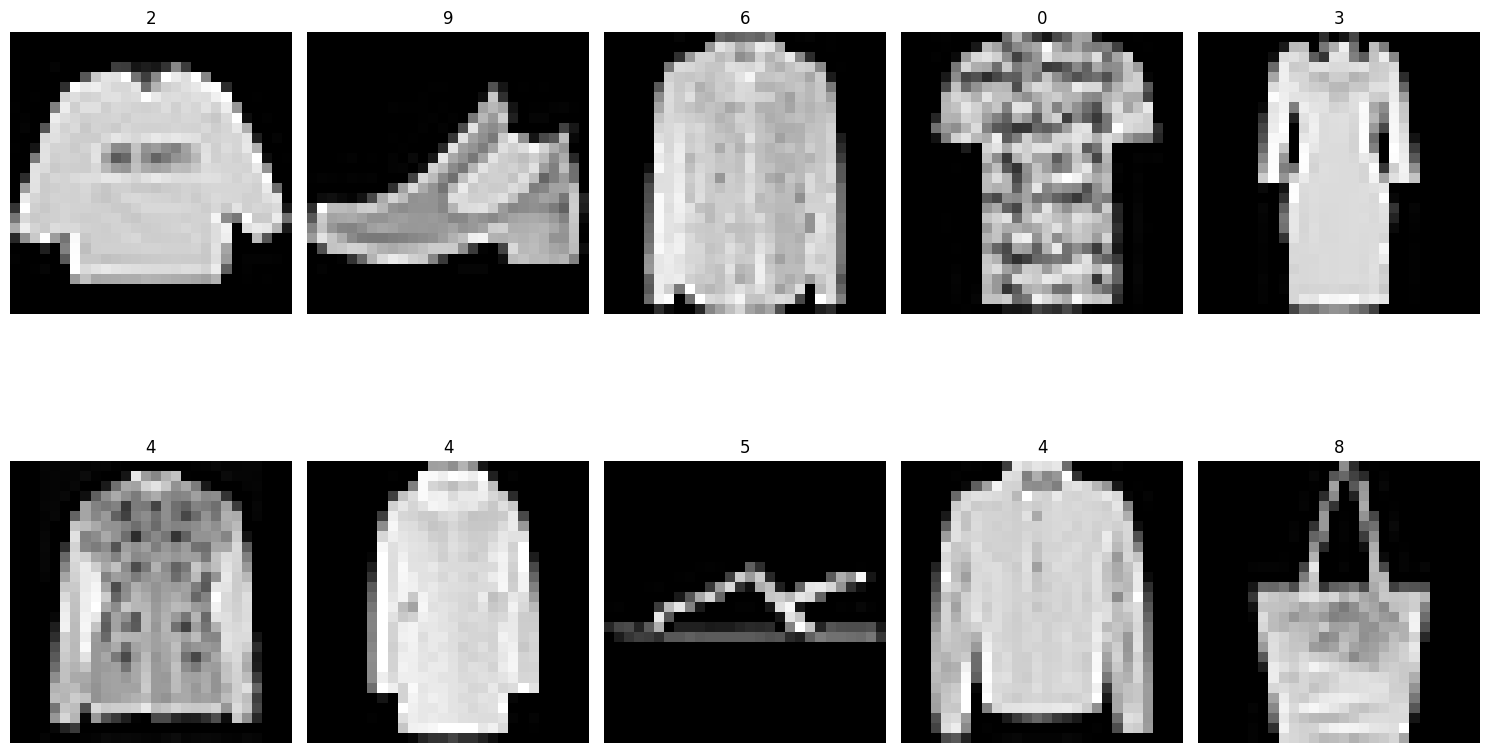

In [50]:
# let's plot first 10 images with 5x5 grid
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    ax[i//5, i%5].imshow(df.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(df.iloc[i, 0])

plt.tight_layout()
plt.show()

## Split the data

In [51]:
# split the data into features and labels
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X.shape, y.shape

((60000, 784), (60000,))

In [52]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48000, 784), (12000, 784), (48000,), (12000,))

## Scale the data

In [53]:
# scaling the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# create dataloader

In [54]:
# create CustomDataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]
        return x, y

In [55]:
# create dataloader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

# Model building

In [56]:
# create model
class MyNN(nn.Module):

    def __init__(self, num_features):
        super().__init__()
        self.model1 = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.model1(x)
        return x


In [57]:
# instatiate the model
model = MyNN(X_train.shape[1])
model.to(device)
# print model summary
summary(model, input_size=(1, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
MyNN                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 128]                  100,480
│    └─BatchNorm1d: 2-2                  [1, 128]                  256
│    └─ReLU: 2-3                         [1, 128]                  --
│    └─Dropout: 2-4                      [1, 128]                  --
│    └─Linear: 2-5                       [1, 64]                   8,256
│    └─BatchNorm1d: 2-6                  [1, 64]                   128
│    └─ReLU: 2-7                         [1, 64]                   --
│    └─Dropout: 2-8                      [1, 64]                   --
│    └─Linear: 2-9                       [1, 10]                   650
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.11
Input size (MB): 0.00
Forward/ba

In [58]:
# set learning rate & and epochs
lr = 0.1
epochs = 100

In [59]:
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)

In [60]:
# training loop
for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:
        # move data to gpu
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # forward pass
        outputs = model(batch_features)

        # calculate loss
        loss = criterion(outputs, batch_labels)

        # zero gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

    print(f"Epoch {epoch+1} loss: {loss.item()}")

Epoch 1 loss: 0.36537641286849976
Epoch 2 loss: 0.4512835741043091
Epoch 3 loss: 0.3569333255290985
Epoch 4 loss: 0.2683650851249695
Epoch 5 loss: 0.37122809886932373
Epoch 6 loss: 0.36522728204727173
Epoch 7 loss: 0.33772632479667664
Epoch 8 loss: 0.43311968445777893
Epoch 9 loss: 0.30320483446121216
Epoch 10 loss: 0.30185532569885254
Epoch 11 loss: 0.3159158229827881
Epoch 12 loss: 0.25452277064323425
Epoch 13 loss: 0.3756435513496399
Epoch 14 loss: 0.34010618925094604
Epoch 15 loss: 0.34248965978622437
Epoch 16 loss: 0.2732696831226349
Epoch 17 loss: 0.3028405010700226
Epoch 18 loss: 0.2854672968387604
Epoch 19 loss: 0.16864433884620667
Epoch 20 loss: 0.4177500009536743
Epoch 21 loss: 0.28852900862693787
Epoch 22 loss: 0.31305909156799316
Epoch 23 loss: 0.30077797174453735
Epoch 24 loss: 0.26577964425086975
Epoch 25 loss: 0.20191076397895813
Epoch 26 loss: 0.26998451352119446
Epoch 27 loss: 0.2766422927379608
Epoch 28 loss: 0.22937150299549103
Epoch 29 loss: 0.3104267716407776
Epoch

# MODEL EVALUATION

In [61]:
# set model to evaluation mode
model.eval()

MyNN(
  (model1): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [62]:
# evaluate model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Accuracy of the model on the test images: 88.59166666666667%


In [63]:
# evaluate model with train data
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Accuracy of the model on the test images: 95.92083333333333%
